In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [298]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [299]:
times = len(train_data) / len(test_data)
print('Train data length is', '%.2f' % times, 'times the length of test data.')
train_percent = (100 / (times + 1)) * times
test_percent = 100 - train_percent
print('This means that the data has', '%.0f' % train_percent + '/' + '%.0f' % test_percent, 'train/test split.')

Train data length is 4.00 times the length of test data.
This means that the data has 80/20 train/test split.


#### EDA and Feature Engineering

In [300]:
train_data.head(2)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33


In [301]:
test_data.head(2)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City
0,0x2318,COIMBRES13DEL01,NaN,NaN,11.003669,76.976494,11.043669,77.016494,30-03-2022,NaN,15:05:00,conditions NaN,NaN,3,Drinks,electric_scooter,1,No,Metropolitian
1,0x3474,BANGRES15DEL01,28,4.6,12.975377,77.696664,13.085377,77.806664,29-03-2022,20:30:00,20:35:00,conditions Windy,Jam,0,Snack,motorcycle,1,No,Metropolitian


In [302]:
# the NaN values in the dataset currently are strings, so let's replace them with the actual np.nan value
train_data = train_data.replace('NaN', np.nan, regex=True)

In [303]:
train_data.isna().sum()

ID                                0
Delivery_person_ID                0
Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weatherconditions               616
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             993
Festival                        228
City                           1200
Time_taken(min)                   0
dtype: int64

In [304]:
# remove useless columns
useless_cols = ['ID', 'Delivery_person_ID', 'Order_Date', 'Vehicle_condition', 'Time_Order_picked']
train_data.drop(useless_cols, axis=1, inplace=True)

In [305]:
train_data.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Weatherconditions,Road_traffic_density,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,37,4.9,22.745049,75.892471,22.765049,75.912471,11:30:00,conditions Sunny,High,Snack,motorcycle,0,No,Urban,(min) 24
1,34,4.5,12.913041,77.683237,13.043041,77.813237,19:45:00,conditions Stormy,Jam,Snack,scooter,1,No,Metropolitian,(min) 33


#### Weather Conditions

In [306]:
print('Old Weather Conditions:', train_data.Weatherconditions.unique())

# we can see that all the weather conditions contain "conditions" in the name so we can remove that
# we can then one hot encode the weather conditions
train_data['Weatherconditions'] = train_data['Weatherconditions'].str.replace("conditions ", "")
print('New Weather Conditions', train_data.Weatherconditions.unique())

Old Weather Conditions: ['conditions Sunny' 'conditions Stormy' 'conditions Sandstorms'
 'conditions Cloudy' 'conditions Fog' 'conditions Windy' nan]
New Weather Conditions ['Sunny' 'Stormy' 'Sandstorms' 'Cloudy' 'Fog' 'Windy' nan]


In [307]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
weather_arr = ohe.fit_transform(train_data[['Weatherconditions']]).toarray()
weather_labels = ohe.categories_[0]
weather = pd.DataFrame(weather_arr, columns=weather_labels)
weather = weather.loc[:, weather.columns.notna()]
weather.head(2)

,Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy
0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0


In [308]:
train_data = pd.concat([train_data, weather], axis=1)
train_data.drop('Weatherconditions', axis=1, inplace=True)

In [309]:
train_data.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Road_traffic_density,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy
0,37,4.9,22.745049,75.892471,22.765049,75.912471,11:30:00,High,Snack,motorcycle,0,No,Urban,(min) 24,0.0,0.0,0.0,0.0,1.0,0.0
1,34,4.5,12.913041,77.683237,13.043041,77.813237,19:45:00,Jam,Snack,scooter,1,No,Metropolitian,(min) 33,0.0,0.0,0.0,1.0,0.0,0.0


#### Traffic Conditions

In [310]:
print('Traffic:', train_data.Road_traffic_density.unique())
train_data['Road_traffic_density'] = train_data['Road_traffic_density'].str.replace(" ", "")
print('Traffic:', train_data.Road_traffic_density.unique())

Traffic: ['High ' 'Jam ' 'Low ' 'Medium ' nan]
Traffic: ['High' 'Jam' 'Low' 'Medium' nan]


In [311]:
# use ordinal encoder
from sklearn.preprocessing import OrdinalEncoder


# save to later check if the same rows have NaN
orig_ind = np.where(train_data['Road_traffic_density'].isna())[0]

oe = OrdinalEncoder(categories=[['Low', 'Medium', 'High', 'Jam']])
train_data.loc[train_data.Road_traffic_density.notna(), ['Road_traffic_density']] = oe.fit_transform(train_data['Road_traffic_density'].dropna().values.reshape(-1,1))

# show that our ordinal encoding did not change the NaN values
new_ind = np.where(train_data['Road_traffic_density'].isna())[0]
print((orig_ind == new_ind).all())

# we can also map the values ourselves instead of using the ordinal encoder
# Even though mapping is much easier here, I wanted to use OrdinalEncoder for this task because it's much more scalable

# traffic_map = {'Low': 0, 'Medium': 1, 'High': 2, 'Jam': 3}
# train_data['Road_traffic_density'] = train_data['Road_traffic_density'].map(traffic_map).fillna(train_data['Road_traffic_density'])

True


In [312]:
train_data.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Road_traffic_density,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy
0,37,4.9,22.745049,75.892471,22.765049,75.912471,11:30:00,2.0,Snack,motorcycle,0,No,Urban,(min) 24,0.0,0.0,0.0,0.0,1.0,0.0
1,34,4.5,12.913041,77.683237,13.043041,77.813237,19:45:00,3.0,Snack,scooter,1,No,Metropolitian,(min) 33,0.0,0.0,0.0,1.0,0.0,0.0


In [313]:
train_data['Time_taken(min)'] = train_data['Time_taken(min)'].str.replace("(min) ", "")

In [314]:
# convert columns to floats, ignore any errors
train_data = train_data.apply(pd.to_numeric, errors='ignore')

#### Age

In [315]:
train_data.Delivery_person_Age.value_counts()

Delivery_person_Age
35.0    2262
36.0    2260
37.0    2227
30.0    2226
38.0    2219
24.0    2210
32.0    2202
22.0    2196
29.0    2191
33.0    2187
28.0    2179
25.0    2174
34.0    2166
26.0    2159
21.0    2153
27.0    2150
39.0    2144
20.0    2136
31.0    2120
23.0    2087
50.0      53
15.0      38
Name: count, dtype: int64

Since ages 50 and 15 are significantly different from the rest, I'm going to see if I can engineer those two age groups myself.

#### Plot Age vs Time Taken

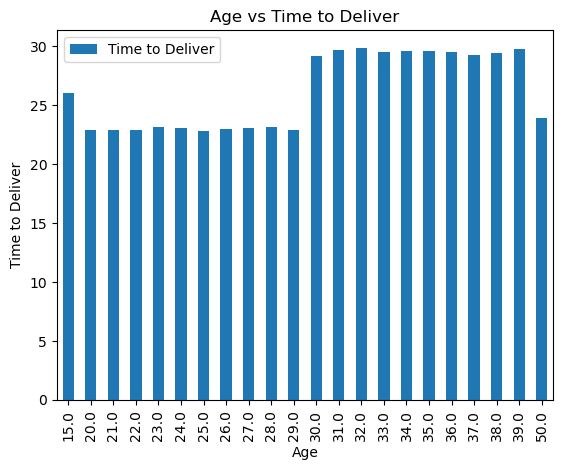

In [316]:
mean_time_age = train_data.groupby('Delivery_person_Age', as_index=False)['Time_taken(min)'].mean()
mean_time_plot = mean_time_age.plot(x='Delivery_person_Age', y='Time_taken(min)', kind='bar', label='Time to Deliver')
mean_time_plot.set_xlabel('Age')
mean_time_plot.set_ylabel('Time to Deliver')
mean_time_plot.set_title('Age vs Time to Deliver');

We see here that delivery drivers of age 20 to 29 all take roughly the same time to deliver food, drivers of age 30 to 39 all take roughly the same time to deliver food and ages 15 and 50 have more unique values. Although the mean time to deliver for a 50 year old is only slightly above that of the highest mean amongst 20-29 year olds, we will leave 50 year olds in their own category since if we are thinking rationally, there shouldn't be any correlation between the speed of a 20-29 year old and a 50 year old.

Note: the reason we want to group those age groups together is to prevent the model from overfitting the training data.

In [317]:
# first change values so that age 20 to 29 have same value (maybe string '20s') and same with 30 to 39 ('30s')

# group ages 20 to 29, and ages 30 to 39, we'll use one hot encoding
# i will not be using ordinal encoding here out of the fear that the model may place significance on the order
# it is unlikely that order should have significance here, since there's no clear reason why a 50 year old takes less time than a 30-39 year old etc

ohe = OneHotEncoder()

age_dict = {15: '15', 50: '50'}
keys_20 = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
keys_30 = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

for key in keys_20:
    age_dict[key] = '20-29'

for key in keys_30:
    age_dict[key] = '30-39'

train_data['Delivery_person_Age'] = train_data['Delivery_person_Age'].map(age_dict).fillna(train_data['Delivery_person_Age'])


In [318]:
train_data['Delivery_person_Age'].unique()

array(['30-39', '20-29', nan, '15', '50'], dtype=object)

In [319]:
age_arr = ohe.fit_transform(train_data[['Delivery_person_Age']]).toarray()
age_labels = ohe.categories_[0]
age = pd.DataFrame(age_arr, columns=age_labels)
age = age.loc[:, age.columns.notna()]
age.head(2)

,15,20-29,30-39,50
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0


In [320]:
train_data = pd.concat([train_data, age], axis=1)
train_data.drop('Delivery_person_Age', inplace=True, axis=1)
train_data.head(2)

,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Road_traffic_density,Type_of_order,Type_of_vehicle,multiple_deliveries,...,Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy,15,20-29,30-39,50
0,4.9,22.745049,75.892471,22.765049,75.912471,11:30:00,2.0,Snack,motorcycle,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,4.5,12.913041,77.683237,13.043041,77.813237,19:45:00,3.0,Snack,scooter,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [321]:
# minutes don't have much significance to time ordered but the hour might so slice to only the hour
train_data['Time_Orderd'] = train_data['Time_Orderd'].str[:2]
train_data['Time_Orderd'].unique()

array(['11', '19', '08', '18', '13', '21', '17', '20', '14', '09', '22',
       '12', '23', nan, '10', '16', '15', '00'], dtype=object)

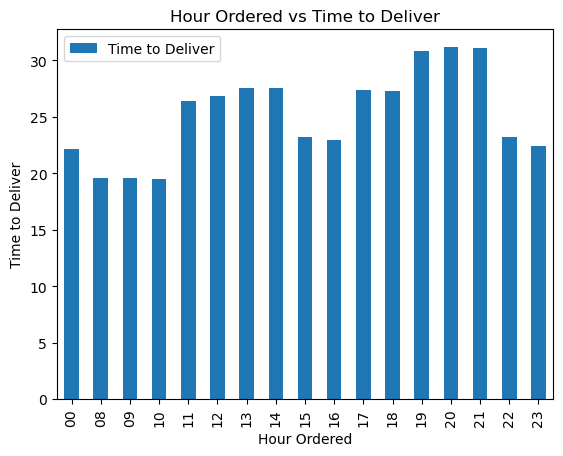

In [322]:
# plot it
mean_time_hour = train_data.groupby('Time_Orderd', as_index=False)['Time_taken(min)'].mean()
mean_time_plot = mean_time_hour.plot(x='Time_Orderd', y='Time_taken(min)', kind='bar', label='Time to Deliver')
mean_time_plot.set_xlabel('Hour Ordered')
mean_time_plot.set_ylabel('Time to Deliver')
mean_time_plot.set_title('Hour Ordered vs Time to Deliver');

We see that it takes longer around lunch time and dinner time to deliver food so we can group between meal times vs non meal times.

In [323]:
filtered_train = train_data[train_data['Time_Orderd'].isna()]
print('Mean time taken in minutes for missing time ordered values:', '%.2f' % filtered_train['Time_taken(min)'].mean())

Mean time taken in minutes for missing time ordered values: 26.31


In [324]:
meal_dict = {}
meal_times = ['11', '12', '13', '14', '17', '18', '19', '20', '21']
non_meal_times = ['00', '08', '09', '10', '15', '16', '22', '23']

for key in meal_times:
    meal_dict[key] = 'Meal_Time'

for key in non_meal_times:
    meal_dict[key] = 'Not_Meal_Time'

train_data['Time_Orderd'] = train_data['Time_Orderd'].map(meal_dict).fillna(train_data['Time_Orderd'])
train_data['Time_Orderd'].unique()

array(['Meal_Time', 'Not_Meal_Time', nan], dtype=object)

In [325]:
ohe = OneHotEncoder()
meal_arr = ohe.fit_transform(train_data[['Time_Orderd']]).toarray()
meal_labels = ohe.categories_[0]
meal = pd.DataFrame(meal_arr, columns=meal_labels)
meal = meal.loc[:, meal.columns.notna()]
meal.head(2)

,Meal_Time,Not_Meal_Time
0,1.0,0.0
1,1.0,0.0


In [326]:
train_data = pd.concat([train_data, meal], axis=1)
train_data.drop('Time_Orderd', inplace=True, axis=1)
train_data.head(3)

,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Road_traffic_density,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,...,Sandstorms,Stormy,Sunny,Windy,15,20-29,30-39,50,Meal_Time,Not_Meal_Time
0,4.9,22.745049,75.892471,22.765049,75.912471,2.0,Snack,motorcycle,0.0,No,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,4.5,12.913041,77.683237,13.043041,77.813237,3.0,Snack,scooter,1.0,No,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,4.4,12.914264,77.678400,12.924264,77.688400,0.0,Drinks,motorcycle,1.0,No,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [327]:
(train_data['Restaurant_latitude'] < 0).sum()

431

In [328]:
def deg_to_rads(deg):
    return deg * np.pi / 180

def my_haversine(row):
    r_lat1 = deg_to_rads(row['Restaurant_latitude'])
    r_lat2 = deg_to_rads(row['Delivery_location_latitude'])
    r_lon1 = deg_to_rads(row['Restaurant_longitude'])
    r_lon2 = deg_to_rads(row['Delivery_location_longitude'])
    dist_lat = r_lat2 - r_lat1
    dist_lon = r_lon2 - r_lon1
    calc_1 = np.sin(dist_lat / 2) ** 2 + np.cos(r_lat1) * np.cos(r_lat2) * (np.sin(dist_lon / 2) ** 2)
    calc_2 = 2 * np.arctan2(np.sqrt(calc_1), np.sqrt(1 - calc_1))
    earth_rad = 6371
    return earth_rad * calc_2

In [329]:
train_data['Distance'] = train_data.apply(my_haversine, axis=1)
train_data.drop(['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude'], axis=1, inplace=True)

In [330]:
train_data.head(2)

,Delivery_person_Ratings,Road_traffic_density,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Cloudy,Fog,...,Stormy,Sunny,Windy,15,20-29,30-39,50,Meal_Time,Not_Meal_Time,Distance
0,4.9,2.0,Snack,motorcycle,0.0,No,Urban,24,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.025149
1,4.5,3.0,Snack,scooter,1.0,No,Metropolitian,33,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,20.183530


#### Split training so we have validation data
I want a 10% validation data split of the whole dataset, so we will split the current training data into a 70/10 train/validation split which means that validation data makes up 12.5% ($10/80$) of the current training data.

In [331]:
from sklearn.model_selection import train_test_split

# train_data, valid_data = train_test_split(train_data, test_size=0.125, random_state=1)